<a href="https://colab.research.google.com/github/hungjoe/HW2/blob/main/%E4%BD%9C%E6%A5%AD2_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### VAE

Epoch 1, Average loss: 166.0124
Epoch 2, Average loss: 122.5238
Epoch 3, Average loss: 115.0768
Epoch 4, Average loss: 112.0297
Epoch 5, Average loss: 110.2170
Epoch 6, Average loss: 109.1496
Epoch 7, Average loss: 108.1962
Epoch 8, Average loss: 107.5528
Epoch 9, Average loss: 107.0378
Epoch 10, Average loss: 106.5652
Epoch 11, Average loss: 106.1866
Epoch 12, Average loss: 105.8538
Epoch 13, Average loss: 105.5875
Epoch 14, Average loss: 105.2950
Epoch 15, Average loss: 105.1213
Epoch 16, Average loss: 104.9034
Epoch 17, Average loss: 104.7594
Epoch 18, Average loss: 104.5210
Epoch 19, Average loss: 104.4041
Epoch 20, Average loss: 104.2337
Epoch 21, Average loss: 104.0763
Epoch 22, Average loss: 104.0348
Epoch 23, Average loss: 103.8306
Epoch 24, Average loss: 103.7592
Epoch 25, Average loss: 103.6300
Epoch 26, Average loss: 103.5518
Epoch 27, Average loss: 103.4584
Epoch 28, Average loss: 103.4190
Epoch 29, Average loss: 103.2650
Epoch 30, Average loss: 103.1819


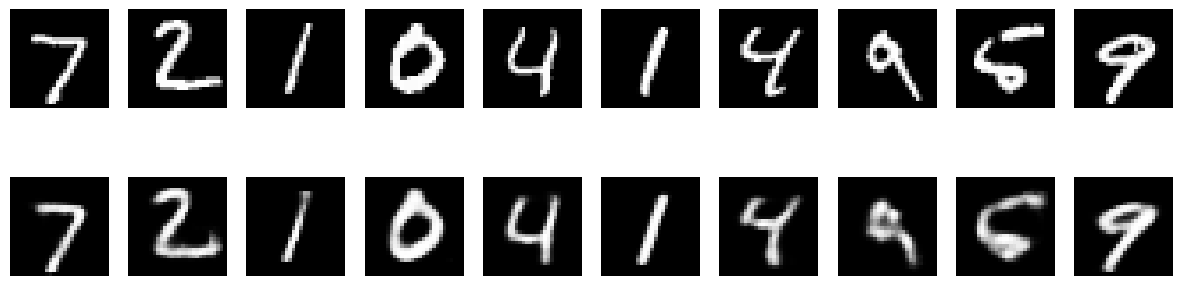

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# =====================
# 1. 資料準備
# =====================
batch_size = 128

transform = transforms.ToTensor()
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# =====================
# 2. 模型設計 (VAE)
# =====================
class VAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=20):
        super(VAE, self).__init__()

        # Encoder
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

        # Decoder
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        h = F.relu(self.fc1(x))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)   # N(0,1)
        return mu + eps * std

    def decode(self, z):
        h = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h))  # 輸出為 0~1

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar


# =====================
# 3. 損失函數 (重建誤差 + KL divergence)
# =====================
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD


# =====================
# 4. 訓練流程
# =====================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

epochs = 30
for epoch in range(1, epochs + 1):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.view(-1, 784).to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    print(f'Epoch {epoch}, Average loss: {train_loss / len(train_loader.dataset):.4f}')


# =====================
# 5. 測試集重建結果可視化
# =====================
model.eval()
with torch.no_grad():
    test_batch, _ = next(iter(test_loader))
    test_batch = test_batch.view(-1, 784).to(device)
    recon_batch, _, _ = model(test_batch)

    # 取前10張
    n = 10
    plt.figure(figsize=(15, 4))
    for i in range(n):
        # 原圖
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(test_batch[i].cpu().view(28, 28), cmap='gray')
        ax.axis("off")

        # 重建圖
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(recon_batch[i].cpu().view(28, 28), cmap='gray')
        ax.axis("off")
    plt.show()


### GAN

準備資料

In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn

# 定義資料轉換，將圖片轉為Tensor並且正規化至[0,1]
transform = transforms.Compose([
    transforms.ToTensor(),
])

# 載入訓練資料集
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)

# 建立資料加載器
train_loader = DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)


In [ ]:
# global dataset settings
import os, math, random, time
from dataclasses import dataclass
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
# 固定隨機種子確保可重現性
torch.manual_seed(42)
BATCH_SIZE = 128

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print('device info : ', device)

def show_grid(tensor, nrow=10, title=None):
    grid = utils.make_grid(tensor.detach().cpu(), nrow=nrow, padding=2, normalize=True)
    h = int(math.ceil(tensor.size(0) / nrow))
    plt.figure(figsize=(nrow*1.2, h*1.2))
    plt.imshow(grid.permute(1, 2, 0))
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

# 存圖小工具
def save_grid(tensor, path, nrow=10):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    grid = utils.make_grid(tensor.detach().cpu(), nrow=nrow, padding=2, normalize=True)
    utils.save_image(grid, path)
    print("Saved:", path)

設計GAN模型

In [ ]:
NZ= 100
class G(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(NZ, 256*7*7)

        self.net = nn.Sequential(
            nn.BatchNorm2d(256),
            nn.ConvTranspose2d(256, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Conv2d(64, 1, 3, 1, 1)
        )
    def forward(self, z):
        # z: [B, NZ]
        h = self.fc(z).view(-1, 256, 7, 7)
        logits = self.net(h)
        x = torch.sigmoid(logits)
        return x

class D(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 64, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten(),
            nn.Linear(128*7*7, 1)
        )
    def forward(self, x):
        # x: [B, 1, 28, 28]
        return self.net(x).view(-1)

G_gan = G().to(device)
D_gan = D().to(device)

optimizer_G = torch.optim.Adam(G_gan.parameters(), lr=1e-4, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(D_gan.parameters(), lr=4e-4, betas=(0.5, 0.999))
bce = nn.BCEWithLogitsLoss()

from tqdm.auto import tqdm

num_epochs = 50

for epoch in range(1, num_epochs+1):
    D_loss_sum = G_loss_sum = 0.0
    for x_real, _ in tqdm(train_loader, desc=f"GAN Epoch {epoch}", leave=False):
        x_real = x_real.to(device)
        bs = x_real.size(0)

        z = torch.randn(bs, NZ, device=device)
        x_fake = G_gan(z).detach()

        logits_real = D_gan(x_real)
        logits_fake = D_gan(x_fake)

        real_targets = torch.empty(bs, device=device).uniform_(0.8, 1.0)
        fake_targets = torch.zeros(bs, device=device)

        loss_D = bce(logits_real, real_targets) + bce(logits_fake, fake_targets)
        optimizer_D.zero_grad()
        loss_D.backward()
        optimizer_D.step()

        z = torch.randn(bs, NZ, device=device)
        x_fake = G_gan(z)
        logits_fake = D_gan(x_fake)
        real_targets_for_G = torch.ones(bs, device=device)
        loss_G = bce(logits_fake, real_targets_for_G)
        optimizer_G.zero_grad()
        loss_G.backward()
        optimizer_G.step()

        D_loss_sum += loss_D.item()
        G_loss_sum += loss_G.item()

    print(f"[GAN] epoch {epoch:02d} | D={D_loss_sum/len(train_loader):.3f} | G={G_loss_sum/len(train_loader):.3f}")

顯示圖像

In [ ]:
G_gan.eval()
with torch.no_grad():
    num_show = 10  # 固定生成10張圖片
    z = torch.randn(num_show, NZ, device=device)
    fake_batch = G_gan(z)

    fake_imgs = fake_batch.detach().cpu()
    show_grid(fake_imgs, nrow=num_show, title="GAN generated pictures")


### cGAN

準備資料

In [ ]:
from torchvision import datasets, transforms

transform = transforms.Compose([
    transforms.ToTensor(),  # 轉成tensor
    transforms.Normalize((0.5,), (0.5,))  # 標準化到[-1, 1]
])

mnist_dataset = datasets.MNIST(
    root="./data",     # 資料儲存位置
    train=True,        # 是否為訓練集
    download=True,     # 若沒資料則下載
    transform=transform
)



設定訓練

In [ ]:
import os, math, random, time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils
import numpy as np

# 設定隨機種子
torch.manual_seed(42)
np.random.seed(42)

# 超參數
batch_size = 128
lr = 2e-4
epochs = 50
z_dim = 100
label_dim = 10
img_dim = 28 * 28
hidden_dim = 256
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('device info : ', device)

train_loader = DataLoader(mnist_dataset, batch_size=batch_size, shuffle=True,num_workers=0, pin_memory=True)

def show_grid(tensor, nrow=10, title=None):
    grid = utils.make_grid(tensor.detach().cpu(), nrow=nrow, padding=2, normalize=True)
    h = int(math.ceil(tensor.size(0) / nrow))
    plt.figure(figsize=(nrow*1.2, h*1.2))
    plt.imshow(grid.permute(1, 2, 0))
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

# 存圖小工具
def save_grid(tensor, path, nrow=10):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    grid = utils.make_grid(tensor.detach().cpu(), nrow=nrow, padding=2, normalize=True)
    utils.save_image(grid, path)
    print("Saved:", path)

設計模型

In [ ]:
from tqdm import tqdm
NZ = 100
NUM_CLASSES = 10
EMB = 16

# Generator 模型
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.embed = nn.Embedding(NUM_CLASSES, EMB)
        self.fc = nn.Linear(NZ + EMB, 256*7*7)
        self.net = nn.Sequential(
            nn.BatchNorm2d(256),
            nn.ConvTranspose2d(256, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Conv2d(64, 1, 3, 1, 1)
        )

    def forward(self, z, y):
        e = self.embed(y)
        h = self.fc(torch.cat([z, e], dim=1)).view(-1, 256, 7, 7)
        logits = self.net(h)
        return logits

# Discriminator 模型
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.embed = nn.Embedding(NUM_CLASSES, 28*28)
        self.conv = nn.Sequential(
            nn.Conv2d(2, 64, 4, 2, 1),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, True),
            nn.Flatten(),
            nn.Linear(128*7*7, 1)
        )

    def forward(self, x, y):
        ymap = self.embed(y).view(-1, 1, 28, 28)
        x = torch.cat([x, ymap], dim=1)
        return self.conv(x).view(-1)

# 初始化模型與優化器
generator = Generator().to(device)
discriminator = Discriminator().to(device)

optimizer_g = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_d = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

criterion = nn.BCEWithLogitsLoss()

# 訓練迴圈
for epoch in range(epochs):
    g_loss_epoch = 0.0
    d_loss_epoch = 0.0

    for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        batch_size_curr = imgs.size(0)
        imgs = imgs.to(device)
        #print(imgs.shape)

        labels = labels.to(device)

        # 產生隨機噪音與隨機標籤
        z = torch.randn(batch_size_curr, NZ).to(device)
        random_labels = torch.randint(0, NUM_CLASSES, (batch_size_curr,), dtype=torch.long).to(device)

        # ===== 訓練 Discriminator（1 次）=====
        discriminator.zero_grad()

        real_labels = torch.full((batch_size_curr,), 0.9, device=device)
        fake_labels = torch.zeros(batch_size_curr, device=device)

        outputs_real = discriminator(imgs, labels)
        d_loss_real = criterion(outputs_real, real_labels)

        fake_imgs = generator(z, random_labels)
        outputs_fake = discriminator(fake_imgs.detach(), random_labels)
        d_loss_fake = criterion(outputs_fake, fake_labels)

        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        optimizer_d.step()

        # ===== 訓練 Generator（1 次）=====
        generator.zero_grad()

        z = torch.randn(batch_size_curr, NZ).to(device)
        random_labels = torch.randint(0, NUM_CLASSES, (batch_size_curr,), dtype=torch.long).to(device)

        fake_imgs = generator(z, random_labels)
        gen_labels = torch.ones(batch_size_curr, device=device)  # 注意：用 1 而不是 0.9
        outputs = discriminator(fake_imgs, random_labels)
        g_loss = criterion(outputs, gen_labels)

        g_loss.backward()
        optimizer_g.step()

        g_loss_epoch += g_loss.item()
        d_loss_epoch += d_loss.item()

    print(f"Epoch [{epoch+1}/{epochs}], G Loss: {g_loss_epoch/len(train_loader):.4f}, D Loss: {d_loss_epoch/len(train_loader):.4f}")

顯示圖像

In [ ]:
import matplotlib.pyplot as plt

def show_cgan_digits_ordered_grid(generator, z_dim=100, label_dim=10, n_per_class=10, device='cpu'):
    generator.eval()
    with torch.no_grad():
        fig, axes = plt.subplots(label_dim, n_per_class, figsize=(n_per_class, label_dim))
        for i in range(label_dim):  # i為數字0~9，每行一類
            z = torch.randn(n_per_class, z_dim).to(device)
            labels = torch.full((n_per_class,), i, dtype=torch.long).to(device) # 創建Long型別的標籤張量
            # labels_onehot = torch.zeros(n_per_class, label_dim).to(device) # 移除 one-hot 編碼
            # labels_onehot[:, i] = 1  # 此行全部是數字 i
            fake_imgs = generator(z, labels).cpu().detach() # 將Long型別的標籤傳入generator
            if fake_imgs.shape[1] == 28*28:
                fake_imgs = fake_imgs.view(-1, 28, 28)
            elif fake_imgs.shape[1] == 1 and len(fake_imgs.shape) == 4:
                fake_imgs = fake_imgs.squeeze(1)
            fake_imgs = fake_imgs * 0.5 + 0.5  # 反標準化
            for j in range(n_per_class):
                axes[i, j].imshow(fake_imgs[j], cmap='gray')
                axes[i, j].axis("off")
        plt.tight_layout()
        plt.show()


show_cgan_digits_ordered_grid(generator, device=device)

### Diffusion Model

Device: cuda


100%|██████████| 9.91M/9.91M [00:01<00:00, 4.97MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 129kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.20MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.76MB/s]


Model params: 4.814049 M


Saved checkpoint: ./ddpm_cond_checkpoints/cond_unet_epoch5.pt
Saved preview: ./samples_cond/preview_epoch5.png


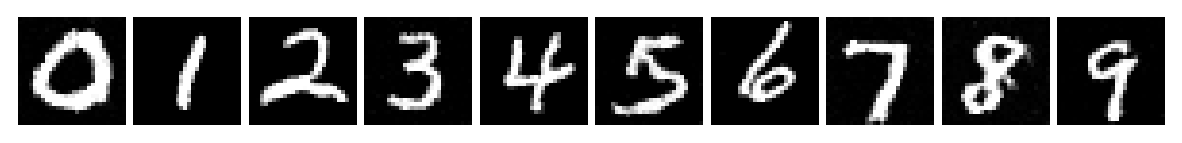

Saved checkpoint: ./ddpm_cond_checkpoints/cond_unet_epoch10.pt
Saved preview: ./samples_cond/preview_epoch10.png


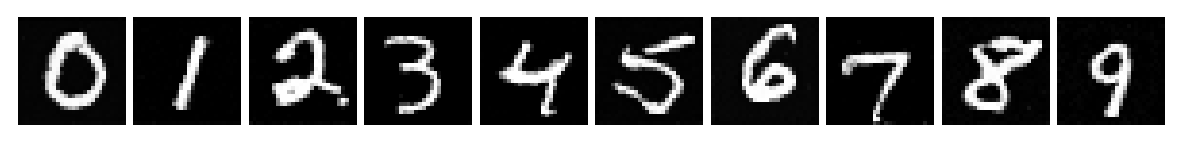

Saved checkpoint: ./ddpm_cond_checkpoints/cond_unet_epoch15.pt
Saved preview: ./samples_cond/preview_epoch15.png


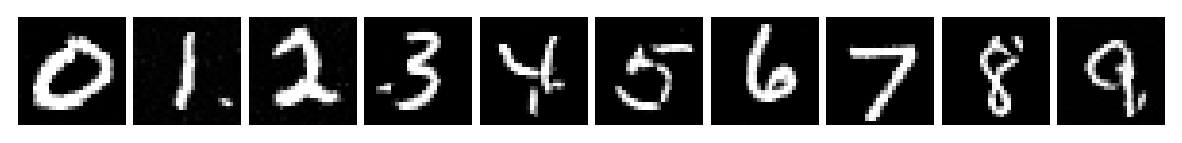

Saved checkpoint: ./ddpm_cond_checkpoints/cond_unet_epoch20.pt
Saved preview: ./samples_cond/preview_epoch20.png


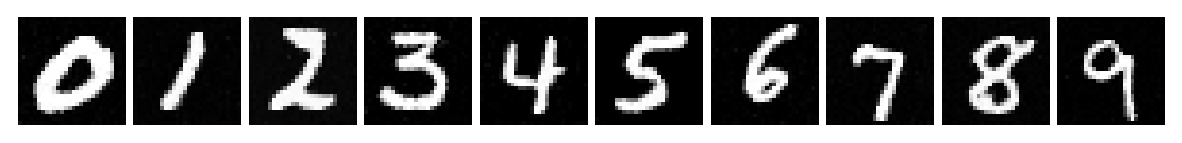

Saved checkpoint: ./ddpm_cond_checkpoints/cond_unet_epoch25.pt
Saved preview: ./samples_cond/preview_epoch25.png


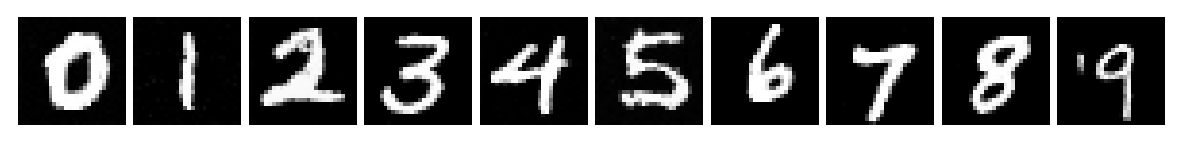

Saved checkpoint: ./ddpm_cond_checkpoints/cond_unet_epoch30.pt
Saved preview: ./samples_cond/preview_epoch30.png


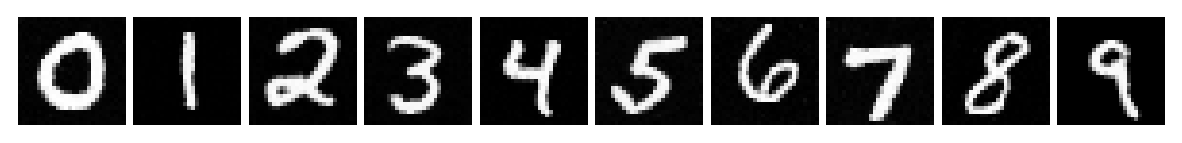

Saved checkpoint: ./ddpm_cond_checkpoints/cond_unet_epoch35.pt
Saved preview: ./samples_cond/preview_epoch35.png


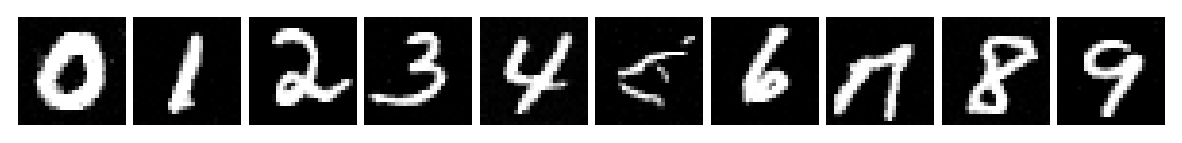

Saved checkpoint: ./ddpm_cond_checkpoints/cond_unet_epoch40.pt
Saved preview: ./samples_cond/preview_epoch40.png


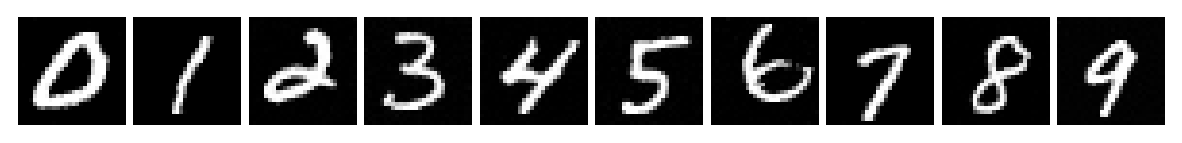

Saved checkpoint: ./ddpm_cond_checkpoints/cond_unet_epoch45.pt
Saved preview: ./samples_cond/preview_epoch45.png


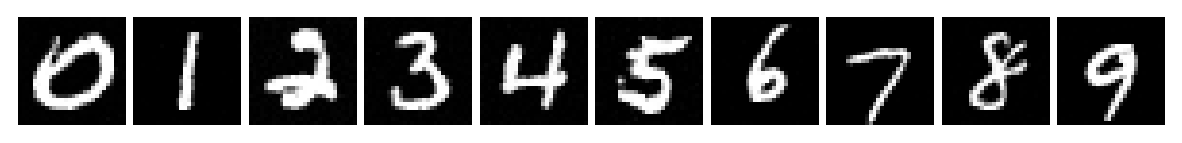

Saved checkpoint: ./ddpm_cond_checkpoints/cond_unet_epoch50.pt
Saved preview: ./samples_cond/preview_epoch50.png


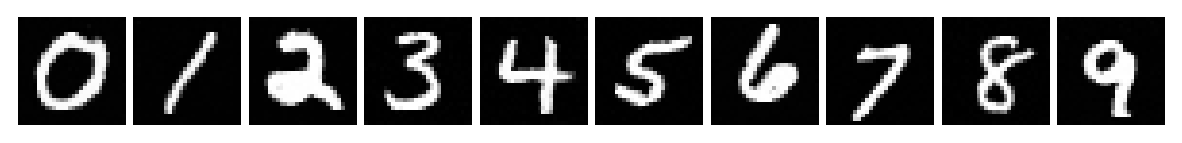

Saved final grid: ./samples_cond/ddim_conditional_first10.png


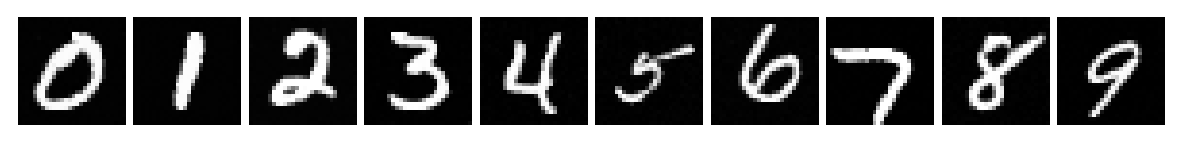

In [ ]:
import os
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import glob

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms, utils
from torch.utils.data import DataLoader

# -------------------------
# extract timestep-dependent values
# -------------------------
def extract(v, t, x_shape):
    t = t.long()
    v = v.to(t.device)
    out = v.gather(0, t)
    return out.view(-1, 1, 1, 1).expand(x_shape)

# -------------------------
# Sinusoidal Pos Embedding
# -------------------------
class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
    def forward(self, t):
        device = t.device
        half = self.dim // 2
        freqs = torch.exp(-math.log(10000) * torch.arange(0, half, device=device).float() / half)
        args = t.float().unsqueeze(-1) * freqs.unsqueeze(0)
        return torch.cat([torch.sin(args), torch.cos(args)], dim=-1)

# -------------------------
# Residual Block
# -------------------------
class ResidualBlock(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim=None, label_emb_dim=None):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.norm1 = nn.GroupNorm(8, out_ch)
        self.norm2 = nn.GroupNorm(8, out_ch)
        self.act = nn.SiLU()
        self.use_time = time_emb_dim is not None
        if self.use_time:
            self.time_proj = nn.Linear(time_emb_dim, out_ch)
        self.use_label = label_emb_dim is not None
        if self.use_label:
            self.label_proj = nn.Linear(label_emb_dim, out_ch)
        if in_ch != out_ch:
            self.res_conv = nn.Conv2d(in_ch, out_ch, 1)
        else:
            self.res_conv = nn.Identity()
    def forward(self, x, t_emb=None, lab_emb=None):
        h = self.conv1(x)
        h = self.norm1(h)
        h = self.act(h)
        if self.use_time and t_emb is not None:
            h = h + self.time_proj(t_emb).view(t_emb.shape[0], -1, 1, 1)
        if self.use_label and lab_emb is not None:
            h = h + self.label_proj(lab_emb).view(lab_emb.shape[0], -1, 1, 1)
        h = self.conv2(h)
        h = self.norm2(h)
        h = self.act(h)
        return h + self.res_conv(x)

# -------------------------
# Conditional U-Net
# -------------------------
class ConditionalUNet(nn.Module):
    def __init__(self, in_ch=1, base_ch=64, time_dim=128, label_dim=32, num_classes=10):
        super().__init__()
        self.time_mlp = nn.Sequential(
            SinusoidalPosEmb(time_dim),
            nn.Linear(time_dim, time_dim*2),
            nn.SiLU(),
            nn.Linear(time_dim*2, time_dim)
        )
        self.label_emb = nn.Embedding(num_classes+1, label_dim)
        self.enc1 = ResidualBlock(in_ch, base_ch, time_emb_dim=time_dim, label_emb_dim=label_dim)
        self.down1 = nn.Conv2d(base_ch, base_ch*2, 4, stride=2, padding=1)
        self.enc2 = ResidualBlock(base_ch*2, base_ch*2, time_emb_dim=time_dim, label_emb_dim=label_dim)
        self.down2 = nn.Conv2d(base_ch*2, base_ch*4, 4, stride=2, padding=1)
        self.enc3 = ResidualBlock(base_ch*4, base_ch*4, time_emb_dim=time_dim, label_emb_dim=label_dim)
        self.bot = ResidualBlock(base_ch*4, base_ch*4, time_emb_dim=time_dim, label_emb_dim=label_dim)
        self.up1 = nn.ConvTranspose2d(base_ch*4, base_ch*2, 4, stride=2, padding=1)
        self.dec1 = ResidualBlock(base_ch*4, base_ch*2, time_emb_dim=time_dim, label_emb_dim=label_dim)
        self.up2 = nn.ConvTranspose2d(base_ch*2, base_ch, 4, stride=2, padding=1)
        self.dec2 = ResidualBlock(base_ch*2, base_ch, time_emb_dim=time_dim, label_emb_dim=label_dim)
        self.out = nn.Conv2d(base_ch, in_ch, 1)
    def forward(self, x, t, y):
        t_emb = self.time_mlp(t)
        y_emb = self.label_emb(y)
        e1 = self.enc1(x, t_emb, y_emb)
        d1 = self.down1(e1)
        e2 = self.enc2(d1, t_emb, y_emb)
        d2 = self.down2(e2)
        e3 = self.enc3(d2, t_emb, y_emb)
        b = self.bot(e3, t_emb, y_emb)
        u1 = self.up1(b)
        u1 = torch.cat([u1, e2], dim=1)
        u1 = self.dec1(u1, t_emb, y_emb)
        u2 = self.up2(u1)
        u2 = torch.cat([u2, e1], dim=1)
        out = self.dec2(u2, t_emb, y_emb)
        return self.out(out)

# -------------------------
# Main
# -------------------------
if __name__ == "__main__":
    seed = 42
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Device:", device)

    # 超參數
    batch_size = 128
    img_size = 28
    channels = 1
    epochs = 50
    lr = 2e-4
    save_dir = "./ddpm_cond_checkpoints"
    os.makedirs(save_dir, exist_ok=True)

    # diffusion
    T = 1000
    beta_start = 1e-4
    beta_end = 2e-2
    betas = torch.linspace(beta_start, beta_end, T, device=device)
    alphas = 1.0 - betas
    alphas_cumprod = torch.cumprod(alphas, dim=0)
    sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
    sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - alphas_cumprod)

    # dataset
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
    train_ds = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)

    # model
    model = ConditionalUNet(in_ch=channels, base_ch=64).to(device)
    print("Model params:", sum(p.numel() for p in model.parameters())/1e6, "M")
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

    # q_sample
    def q_sample(x0, t, noise=None):
        if noise is None:
            noise = torch.randn_like(x0)
        a_t = extract(sqrt_alphas_cumprod, t, x0.shape)
        b_t = extract(sqrt_one_minus_alphas_cumprod, t, x0.shape)
        return a_t * x0 + b_t * noise

    def ddim_sample(model, shape, device, ddim_steps=50, eta=0.0, guidance_scale=3.0, target_label=0):
        model.eval()
        B = shape[0]
        timesteps = np.linspace(0, T-1, ddim_steps, dtype=int)[::-1].copy()
        timesteps = torch.from_numpy(timesteps).long().to(device)
        x = torch.randn(shape, device=device)

        def get_alpha(idx):
            return alphas_cumprod[idx].to(device)

        for i in range(ddim_steps):
            t = timesteps[i]
            t_next = timesteps[i+1] if i+1 < ddim_steps else torch.tensor(0, device=device, dtype=torch.long)
            t_b = torch.full((B,), t, device=device, dtype=torch.long)

            if isinstance(target_label, int):
                y_cond = torch.full((B,), target_label, dtype=torch.long, device=device)
            else:
                y_cond = torch.tensor(target_label, dtype=torch.long, device=device)
            y_uncond = torch.full((B,), null_label, dtype=torch.long, device=device)

            with torch.no_grad():
                eps_cond = model(x, t_b, y_cond)
                eps_uncond = model(x, t_b, y_uncond)
                eps = eps_uncond + guidance_scale * (eps_cond - eps_uncond)

            a_t = get_alpha(t).view(1,1,1,1)
            a_next = get_alpha(t_next).view(1,1,1,1)
            sqrt_a_t = torch.sqrt(a_t)
            sqrt_a_next = torch.sqrt(a_next)

            x0_pred = (x - torch.sqrt(1 - a_t) * eps) / sqrt_a_t
            dir_xt = torch.sqrt(1.0 - a_next) * eps
            x = sqrt_a_next * x0_pred + dir_xt

            if eta > 0 and i < ddim_steps - 1:
                sigma = eta * torch.sqrt((1 - a_next) / (1 - a_t) * (1 - a_t / a_next))
                x = x + sigma * torch.randn_like(x)

        return x

    # 超參數
    num_classes = 10
    null_label = num_classes
    p_uncond = 0.1

    # -------------------------
    # 訓練
    # -------------------------
    print_every = 100
    global_step = 0
    for epoch in range(epochs):
        model.train()
        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)
        running_loss = 0.0
        for imgs, labels in loop:
            imgs, labels = imgs.to(device), labels.to(device)
            B = imgs.shape[0]
            t = torch.randint(0, T, (B,), device=device).long()
            noise = torch.randn_like(imgs)
            x_t = q_sample(imgs, t, noise=noise)
            y = labels.clone()
            mask = (torch.rand(B, device=device) < p_uncond)
            y[mask] = null_label

            pred_noise = model(x_t, t, y)
            loss = F.mse_loss(pred_noise, noise)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            global_step += 1
            if global_step % print_every == 0:
                loop.set_postfix(loss=running_loss / (global_step % 1000 + 1))

        if (epoch + 1) % 5 == 0 or (epoch + 1) == epochs:
            ckpt_path = os.path.join(save_dir, f"cond_unet_epoch{epoch+1}.pt")
            torch.save(model.state_dict(), ckpt_path)
            print(f"Saved checkpoint: {ckpt_path}")

            # 模型生成圖片
            model.eval()
            samples = []
            for label in range(10):
                out = ddim_sample(model, (1, channels, img_size, img_size), device,
                                  ddim_steps=50, eta=0.0, guidance_scale=3.0, target_label=label)
                samples.append(out.cpu())
            samples = torch.cat(samples, dim=0)
            samples = (samples.clamp(-1,1) + 1) / 2.0
            os.makedirs("./samples_cond", exist_ok=True)
            preview_path = f"./samples_cond/preview_epoch{epoch+1}.png"
            grid = utils.make_grid(samples, nrow=10, pad_value=1.0)
            utils.save_image(grid, preview_path)
            print(f"Saved preview: {preview_path}")


            img = plt.imread(preview_path)
            plt.figure(figsize=(15,2))
            plt.imshow(img, cmap="gray")
            plt.axis("off")
            plt.show()

    # -------------------------
    # 最後再生成 0~9 共 10 張
    # -------------------------
    model.eval()
    samples = []
    labels_list = []
    for label in range(10):
        out = ddim_sample(model, (1, channels, img_size, img_size), device,
                          ddim_steps=50, eta=0.0, guidance_scale=3.0, target_label=label)
        samples.append(out.cpu())
        labels_list.append(label)
    samples = torch.cat(samples, dim=0)
    samples = (samples.clamp(-1,1) + 1) / 2.0
    os.makedirs("./samples_cond", exist_ok=True)
    grid = utils.make_grid(samples, nrow=10, pad_value=1.0)
    grid_path = "./samples_cond/ddim_conditional_first10.png"
    utils.save_image(grid, grid_path)
    print(f"Saved final grid: {grid_path}")

    # 顯示 10 張
    img = plt.imread(grid_path)
    plt.figure(figsize=(15,2))
    plt.imshow(img, cmap="gray")
    plt.axis("off")
    plt.show()
